Import some libraries

In [1]:
import torch
from torchvision import datasets, transforms
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary

It's a neural network model class inheriting from torch.nn.Module.
The layers defined are:
Two convolutional layers (conv1 and conv2) with MaxPooling and ReLU activations in between.
Dropout (conv2_drop) after the second convolution.
Fully connected layers (fc1, fc2, fc3) for classification. Input and Output dimensions are mentioned with each layer of model.
The forward() method defines how the data passes through the layers of the network.
MNIST training and validation datasets are prepared using torchvision.datasets and DataLoader.

In [2]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.conv2_drop = nn.Dropout2d()

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        '''
        N - batch size
        C - n image channels (1 for mnist)
        H - height of image, will be 32 for this skeleton code
        W - width of image, will be 32 for this skeleton code
        Input dimensions: [N,C,H,W]
        Output dimensions: [N,n_classes]
        Note: this will be called when you do net(x)
        '''
        x = self.conv1(x) #---> (w-f + 2P) +1 : [N, 6, 28, 28]
        x = self.relu(x)
        x = self.pool(x)  #                   : [N, 6, 14, 14]

        x = self.conv2(x) #                   : [N, 16, 10, 10]

        x = self.conv2_drop(x)

        x = self.relu(x)
        x = self.pool(x)  #                   : [N, 16, 5, 5]

        x = x.view(-1, 400) #---> 16 * 5 * 5

        x = self.fc1(x)   #--> 120
        x = self.fc2(x)   #--> 84
        x = self.fc3(x)   #--> 10

        return x

In [3]:
from torchsummary import summary

net = Net()
summary(net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
         Dropout2d-5           [-1, 16, 10, 10]               0
              ReLU-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.24
Estimated Tot

This function calculates the accuracy of model predictions by identifying the class with the highest probability, counting correct predictions by comparing them to the true labels, and computing accuracy by dividing the count of accurate predictions by the total number of samples.

In [4]:
def compute_accuracy(prediction,gt_logits):
    prediction = np.argmax(prediction, axis=1)
    acc = np.sum(prediction == gt_logits) / len(gt_logits)
    return acc

The transform normalizes and converts images from PIL format to [0,1] range. Dataloaders manage batching and shuffling, while num_workers prefetches data concurrently during training to enhance speed.

In [5]:
batch_size = 100
transform=transforms.ToTensor()
dataset_train = datasets.MNIST('data', train=True, download=True,transform=transform)
dataset_val = datasets.MNIST('data', train=False, download=True,transform=transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=batch_size,shuffle=True,num_workers=4)
# build network
net = Net()

100%|██████████| 9912422/9912422 [00:00<00:00, 251871732.35it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30397915.64it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64886160.31it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14642989.06it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
print(dataset_train)
print("Training Samples: ", len(dataset_train))

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Training Samples:  60000


In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
learning_rate = 0.05
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,  momentum=0.9)


In [9]:
if __name__ == '__main__':
    global_it = 0 # keep track of total number of iterations elapsed
    train_losses = [] # this stuff here is to track training statistics
    train_accuracies = []
    val_iterations = []
    val_losses = []
    val_accuracies = []
    for epoch in range(4): # an epoch is # of iterations to go through the whole training set
        net.train()
        for im, label in dataloader_train: # the dataloader is an iterator, will shuffle, then go through all data once,
            # Center data and pad to 32x32, for convienence
            im = im - 0.5
            im = torch.nn.functional.pad(im,[2,2,2,2,0,0,0,0])

            # Zero out the gradients, the new gradients will not be added to the existing gradients.
            optimizer.zero_grad()

            # get prediction from network, calling the object like a function invokes its forward() method
            pred = net(im)

            # compute the loss
            loss = loss_fn(pred, label)

            # compute the accuracy, we will have to convert to numpy tensorfs first
            # .cpu() moves the tensor to the device, here it is pointless because it is already cpu, but must be done when we use gpus
            # .detach() tells torch that gradients will not flow through this operation, MUST be done before we get the numpy array
            # .numpy() gets the numpy array
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())

            # compute gradient in respect to the loss.
            loss.backward()

            # take a step of SGD, call this through the optimizer!


            optimizer.step()

            # store stats for this iteration
            # note, if the tensor is a scalar, .item() retrieves the value as a python primative
            train_losses.append(loss.item())
            train_accuracies.append(accuracy)

            # print out stats every 10 its
            if global_it % 10 == 0:
                print(f'Iteration: {global_it} | Loss: {loss.item()} | Accuracy: {accuracy}')

            # increment
            global_it += 1

        print('Validating...')
        net.eval()
        cur_val_losses = []
        cur_val_accuracies = []
        for im, label in dataloader_val:
            with torch.no_grad():
                # Center data and pad to 32x32, for convienence
                im = im - 0.5
                im = torch.nn.functional.pad(im,[2,2,2,2,0,0,0,0])

                # get prediction from network
                pred = net(im)

                # compute loss
                loss = loss_fn(pred, label)

                # compute accuracy
                accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())

                # collect stats for this iteration
                cur_val_losses.append(loss.item())
                cur_val_accuracies.append(accuracy.item())
        # take mean over entire validation set
        avg_val_loss = np.array(cur_val_losses).mean()
        avg_val_accuracies = np.array(cur_val_accuracies).mean()
        val_iterations.append(global_it)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracies)
        print(f'Average validation loss: {avg_val_loss}')
        print('Saving checkpoint')

        # save parameters of network
        # Note other things can have states (certain optimizers)
        # you would need to save these things to resume training
        # but we're not doing that here
        torch.save(net.state_dict(),f'epoch-{epoch:04d}.pth')

    print('Training complete')
    print('Plotting training stats')

    plt.ioff()
    plt.plot(train_losses,label='Training')
    plt.plot(val_iterations,val_losses,label='Validation')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training-loss.png')
    plt.show()
    plt.clf()

    plt.plot(train_accuracies,label='Training')
    plt.plot(val_iterations,val_accuracies,label='Validation')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('training-acc.png')
    plt.show()

Iteration: 0 | Loss: 2.300081729888916 | Accuracy: 0.09
Iteration: 10 | Loss: 2.2996737957000732 | Accuracy: 0.05
Iteration: 20 | Loss: 2.2367215156555176 | Accuracy: 0.25
Iteration: 30 | Loss: 1.8022633790969849 | Accuracy: 0.33
Iteration: 40 | Loss: 1.0661168098449707 | Accuracy: 0.63
Iteration: 50 | Loss: 0.7642691731452942 | Accuracy: 0.75
Iteration: 60 | Loss: 0.6293493509292603 | Accuracy: 0.77
Iteration: 70 | Loss: 0.5057477355003357 | Accuracy: 0.82
Iteration: 80 | Loss: 0.30450108647346497 | Accuracy: 0.92
Iteration: 90 | Loss: 0.33637526631355286 | Accuracy: 0.88
Iteration: 100 | Loss: 0.3214360475540161 | Accuracy: 0.91
Iteration: 110 | Loss: 0.377475380897522 | Accuracy: 0.84
Iteration: 120 | Loss: 0.3626715838909149 | Accuracy: 0.87
Iteration: 130 | Loss: 0.30453455448150635 | Accuracy: 0.94
Iteration: 140 | Loss: 0.19744867086410522 | Accuracy: 0.94
Iteration: 150 | Loss: 0.20455652475357056 | Accuracy: 0.93
Iteration: 160 | Loss: 0.26259174942970276 | Accuracy: 0.89
Iter

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

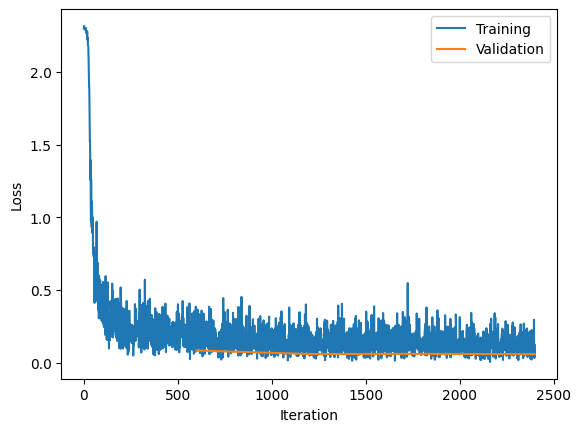

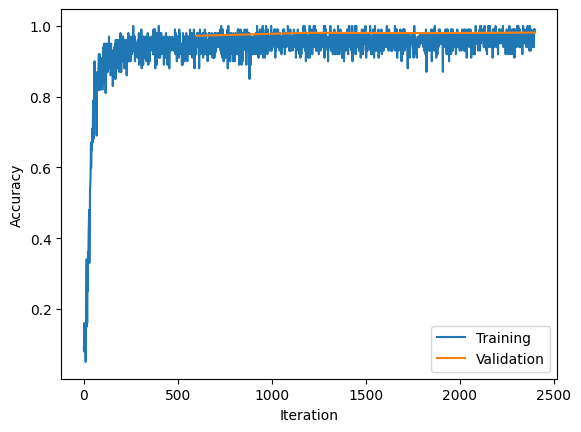

In [10]:
# ------To plot in notebook

%matplotlib inline
plt.ioff()
plt.plot(train_losses,label='Training')
plt.plot(val_iterations,val_losses,label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training-loss.png')
plt.show()
plt.clf()

plt.plot(train_accuracies,label='Training')
plt.plot(val_iterations,val_accuracies,label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training-acc.png')
plt.show()

In [11]:
# Load the checkpoint we made, and load the stat into the model
ckpt = torch.load('epoch-0003.pth')
net.load_state_dict(ckpt)

<All keys matched successfully>

Notice that this loop is exactly the same as training loop, except there is one more line "net.eval()" we put the network mode to evaluation because now we are testing the model

In [12]:
if __name__ == '__main__':
    net.eval()
    cur_val_losses = []
    cur_val_accuracies = []
    for im, label in dataloader_val:
        with torch.no_grad():
            # Center data and pad to 32x32
            im = im - 0.5
            im = torch.nn.functional.pad(im,[2,2,2,2,0,0,0,0])

            # get prediction from network
            pred = net(im)

            # compute loss
            loss = loss_fn(pred, label)

            # compute accuracy
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            cur_val_losses.append(loss.item())
            cur_val_accuracies.append(accuracy.item())

    avg_val_loss = np.array(cur_val_losses).mean()
    avg_val_accuracies = np.array(cur_val_accuracies).mean()
    print(f'Average validation loss: {avg_val_loss}')
    print(f'Average validation Accuracy: {avg_val_accuracies}')

Average validation loss: 0.05859465692425147
Average validation Accuracy: 0.9812000000000002


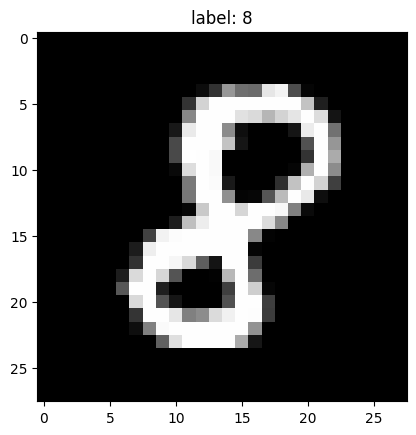

torch.Size([1, 1, 32, 32])
Predicted Label: 8


In [13]:
import random

# Predicting Data Sample from Val Dataset

idx = random.randint(0, len(dataset_val) - 1)

# get the image and label at the selected index
image, label = dataset_val[idx]

# show sample image
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f'label: {label}')
plt.show()

# batch dimension
image = image.unsqueeze(0)

# add paddding as network is for 32
im = torch.nn.functional.pad(image,[2,2,2,2,0,0,0,0])
print(im.shape)

pred = net(im) # predict
pred_label = torch.argmax(pred).item()

#predicted label
print(f'Predicted Label: {pred_label}')
